# Introducing word embeddings

> ⚠️ The cells of this notebook have been executed to facilitate the use of [readthedocs.io](applied-language-technology.readthedocs.io/). If you wish to work through the notebook step-by-step, go to the *Kernel* menu and select *Restart & Clear Output*.

This section introduces you to *word embeddings*, a technique for learning numerical representations that approximate the lexical meaning of words, and the underlying *distributional hypothesis*.

After reading this section, you should:

 - understand the distributional hypothesis
 - how different aspects of linguistic structure can be represented numerically
 - understand how word embeddings are learned

## Background: the distributional hypothesis and word embeddings

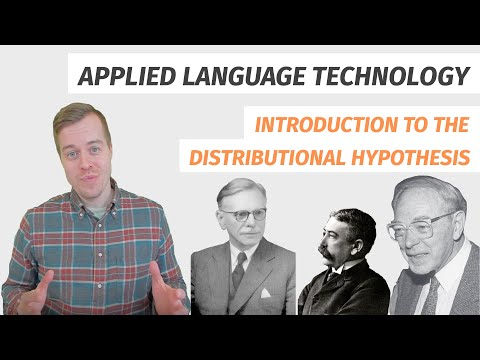

In [1]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('ZB28symH8Mg', height=350, width=600)

The inspiration for word embeddings is often attributed to the following observation by the English linguist [J.R. Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth):

> "You shall know a word by the company it keeps."

What Firth means is that the meaning of a word can be inferred by examining the word in its context of occurrence.

This observation reflects Firth's broader interest in studying words in their context of occurrence:

> "The complete meaning of a word is always contextual, and no study of meaning apart from context can be taken seriously." (Firth [1935](https://doi.org/10.1111/j.1467-968X.1935.tb01254.x): 37)

> "Meaning, that is to say, is to be regarded as a complex of contextual relations, and phonetics, grammar, 
lexicography, and semantics each handles its own components of the complex in its appropriate context." (Firth [1935](https://doi.org/10.1111/j.1467-968X.1935.tb01254.x): 54)

Firth's observation about the role of context can also be related to the so-called **distributional hypothesis** proposed by Harris ([1954](https://doi.org/10.1080/00437956.1954.11659520)), which assumes that linguistic elements such as words may be characterised by their distribution in the linguistic system.

> "The distribution of an element will be understood as the sum of all its environments. An environment of an element A is an existing array of its co-occurrents, i.e. the other elements, each in a particular position, with which A occurs to yield an utterance. A's co-occurrents in a particular position are called its selection for that position." (Harris [1954](https://doi.org/10.1080/00437956.1954.11659520): 146)

The term distribution refers to the way words co-occur with each other: the distribution of words is *not random*, but can be characterised using probabilities, and some words are more likely to co-occur with each other than others.

Put differently, Boleda ([2020](https://doi.org/10.1146/annurev-linguistics-011619-030303): 214) summarises the distributional hypothesis as follows:

> Similarity in meaning results in similarity of linguistic distribution.

To exemplify, given the verb "enjoy", you could probably come up with words that *could* be more or less likely to precede or follow this word. Given some context, you could probably also come up with a way of replacing the verb "enjoy" without changing the meaning too much (e.g. "like")! According to the distributional hypothesis, these verbs can be used interchangeably, because they occur in similar linguistic contexts.

Sahlgren ([2008](http://linguistica.sns.it/RdL/20.1/Sahlgren.pdf): 34) argues that the distributional hypothesis has its roots in "structuralist soil", that is, [Ferdinand de Saussure](https://en.wikipedia.org/wiki/Ferdinand_de_Saussure)'s ideas about the structure of language.

Saussure described the structure of language from two perspectives: *langue*, the abstract system constituted by language, and *parole*, particular instances of language produced by the underlying system of *langue*. 

Saussure characterised *langue* as having *paradigmatic* and *syntagmatic* axes of organisation, which allow making choices between alternatives and combining these selections into larger structures. The paradigmatic alternatives emerge through oppositions: alternatives can only be identified by what they are and what they are not.

![](img/parasyn.svg)

Saussure's and Firth's ideas were taken further by [M.A.K. Halliday](https://en.wikipedia.org/wiki/Michael_Halliday) ([1961](https://doi.org/10.1080/00437956.1961.11659756)), who incorporated them into the foundations of a theory of language known as [systemic functional linguistics](https://en.wikipedia.org/wiki/Systemic_functional_linguistics) (for a recent overview of the field, see Martin [2016](https://doi.org/10.1080/00437956.2016.1141939)). 

In contrast to Saussure's view of language as a static system of oppositions, Halliday emphasises the role of *choice* for language. 

Halliday argues that language is defined by *meaning potential*, which is realised *dynamically* by making choices within intersecting linguistic systems. These systems are provided by the *lexicogrammar*, which Halliday describes as a cline: the choices made within language become increasingly delicate when moving from grammar to lexis (see e.g. Fontaine [2017](https://doi.org/10.1186/s40554-017-0051-7)).

Against this backdrop, the following sections explore the distributional hypothesis from both syntagmatic and paradigmatic perspectives, as proposed in Sahlgren ([2008](http://linguistica.sns.it/RdL/20.1/Sahlgren.pdf)).

## Exploring the distributional hypothesis

### A syntagmatic perspective

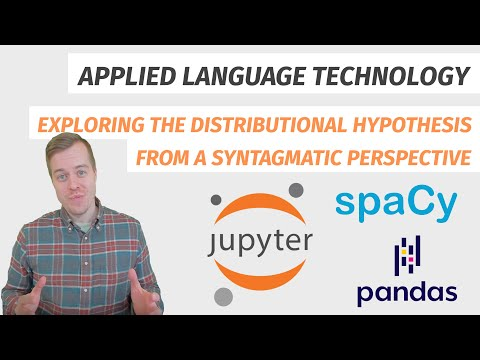

In [2]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('zwtvIomLJSw', height=350, width=600)

In this section we explore the distributional hypothesis from a syntagmatic perspective, that is, we seek to describe syntagmatic structures that result from combining paradigmatic choices into larger units.

To do so, we must first determine the scope of an analytical unit for examining syntagmatic structures.

The scope of analytical units may be motivated linguistically, as exemplified by observing co-occurring words within a clause or a sentence, or may simply involve observing words that occur within an arbitrary distance of one another.

To find co-occurring words, we must retrieve unique words and count their occurrences across units of analysis.

To get started, let's import the spaCy library and load a medium-sized language model for English.

In [3]:
# Import the spaCy library
import spacy

# Load a medium-sized language model for English; assign to variable 'nlp'
nlp = spacy.load('en_core_web_md')

We then define a toy example that consists of some clauses in a Python list, which we assign to the variable `examples`.

In [4]:
# Create list
examples = ["Helsinki is the capital of Finland",
            "Tallinn is the capital of Estonia",
            "The two capitals are joined by a ferry connection",
            "Travelling between Helsinki and Tallinn takes about two hours",
            "Ferries depart from downtown Helsinki and Tallinn"]

# Print list contents
print(examples)

['Helsinki is the capital of Finland', 'Tallinn is the capital of Estonia', 'The two capitals are joined by a ferry connection', 'Travelling between Helsinki and Tallinn takes about two hours', 'Ferries depart from downtown Helsinki and Tallinn']


We can then feed this list to the English language model under `nlp` and store the resulting _Doc_ objects into a list under the variable `docs`.

To process the example clauses effectively, we can use the `pipe()` method introduced in [Part II](../notebooks/part_ii/04_basic_nlp_continued.ipynb#Processing-texts-efficiently), which takes a list as input.

The `pipe()` method returns a generator object, which we have to cast into a list using Python's `list()` function.

In [5]:
# Feed the list of example sentences 'examples' to the pipe() method.
# Cast the result into a list and store under the variable 'docs'.
docs = list(nlp.pipe(examples))

# Call the variable to check the output
docs

[Helsinki is the capital of Finland,
 Tallinn is the capital of Estonia,
 The two capitals are joined by a ferry connection,
 Travelling between Helsinki and Tallinn takes about two hours,
 Ferries depart from downtown Helsinki and Tallinn]

For convenience and simplicity, we examine the co-occurrences of lemmas rather than the inflected forms of words. 

To count the lemmas in each clause, we must import the `LEMMA` object from spaCy's `attrs` module. 

`LEMMA` is a spaCy object that refers to this particular linguistic feature, which we can pass to the `count_by()` method of a *Doc* object to instruct *spaCy* to count these linguistic features.

In [6]:
# Import the LEMMA object from the 'attrs' module of spaCy
from spacy.attrs import LEMMA

We then define a Python *dictionary comprehension* to count the lemmas in each *Doc* object in the list `docs`.

A dictionary comprehension is declared using curly braces `{ }`, which are also used to designate a dictionary in Python.

Because Python dictionaries consist of *keys* and *values*, we need **two** items to populate the new `lemma_counts` dictionary using a dictionary comprehension:

 1. `i` refers to the number returned by the `enumerate` function that keeps count of items in the list `docs`
 2. `doc` refers to the current document in `docs`, our _list_ of _Doc_ objects
 
Note that on the right-hand side of the `for` statement, these two variables are separated by a comma.
 
The left-hand side of the `for` statement defines what is actually stored in the `lemma_counts` dictionary. 

In this case, we store the count `i` as the *key* and assign the output of the `count_by` method as the *value*.

On the left-hand side, these variables are separated by a colon.

In [7]:
# Use a dictionary comprehension to populate the 'lemma_counts' dictionary
lemma_counts = {i: doc.count_by(LEMMA) for i, doc in enumerate(docs)}

# Call the variable to check the output
lemma_counts

{0: {332692160570289739: 1,
  10382539506755952630: 1,
  7425985699627899538: 1,
  15481038060779608540: 1,
  886050111519832510: 1,
  4881666681900411319: 1},
 1: {7392857733388117912: 1,
  10382539506755952630: 1,
  7425985699627899538: 1,
  15481038060779608540: 1,
  886050111519832510: 1,
  15428882767191480669: 1},
 2: {7425985699627899538: 1,
  11711838292424000352: 1,
  15481038060779608540: 1,
  10382539506755952630: 1,
  16238441731120403936: 1,
  16764210730586636600: 1,
  11901859001352538922: 1,
  16008623592554433546: 1,
  14753437861310164020: 1},
 3: {9016120516514741834: 1,
  7508752285157982505: 1,
  332692160570289739: 1,
  2283656566040971221: 1,
  7392857733388117912: 1,
  6789454535283781228: 1,
  942632335873952620: 1,
  11711838292424000352: 1,
  9748623380567160636: 1},
 4: {16008623592554433546: 1,
  11568774473013387390: 1,
  7831658034963690409: 1,
  18137549281339502438: 1,
  332692160570289739: 1,
  2283656566040971221: 1,
  7392857733388117912: 1}}

The keys of the `lemma_counts` dictionary correspond to indices of *Doc* objects in the list `docs`, whereas the *values* consist of dictionaries!

These dictionaries clearly appear to report some counts, but the sequences of numbers used as the keys may appear strange. 

As you may recall from the [previous section](03_pattern_matching.ipynb), spaCy uses sequences of numbers as identifiers for *Lexeme* objects in the *Language* object's *Vocabulary*.

We can verify this by retrieving the *Lexeme* object with the identifier `332692160570289739` from the *Vocabulary*, which can be accessed using the `vocab` attribute of the language model stored under `nlp`.

We then use the `text` attribute of the *Lexeme* object to get the human-readable form.

In [8]:
# Fetch a Lexeme from the model Vocabulary under 'vocab'; get attribute 'text'
nlp.vocab[332692160570289739].text

'Helsinki'

As you can see, this sequence of numbers identifies the *Lexeme* with the text "Helsinki".

We can map the *Lexeme* objects to their human-readable forms by performing a slightly more complicated dictionary comprehension.

Below we update the `lemma_counts` dictionary in two steps.

First, we loop over *key* (`i`) and *value* (`counter`) pairs, which are accessible through the `items()` method of the `lemma_counts` dictionary that we just created.
 
This is done by the part on the **right** hand side of the **second** `for` statement: 
 
```python
{... for i, counter in lemma_counts.items()}
```
 
This gives us two things during each loop: 1. a number under `i`, which can be used to index the list `docs` for spaCy *Doc* objects and 2. a Python dictionary with *Lexeme* identifiers as keys and counts as values.

Second, we update the *keys* and *values* of the `lemma_counts` dictionary by preserving the original key `i` that allows identifying the *Doc* objects in the list `docs`.
 
Because the dictionary *value* stored under `counter` is another dictionary, we must define yet another dictionary comprehension!
 
```python
{i: {docs[i].vocab[k].text: v for k, v in counter.items()} for ...}
```
 
This dictionary comprehension is just like the one above, but this time we update the *keys* of the `counter` dictionary to replace the numerical identifiers for *Lexemes* with human-readable text:
 
```python
{docs[i].vocab[k].text: v for ...}
```
 
On the left-hand side of the colon `:` that separates keys and values in the dictionary that we are creating, we access the *Doc* objects in the list `docs` using brackets and by referring to the current number under `i`. 
 
We then provide the *Lexeme* object under `k` to the `vocab` attribute to fetch the contents of the attribute `text`.
 
Note that we do not do anything with the counts stored under the variable `v` on the right-hand side of the colon `:`, but simply carry them over to the newly-created dictionary!
 
This illustrates just how much a single line of Python can achieve using dictionary comprehensions nested within one another.

In [9]:
# Use a dictionary comprehension to replace the keys of the 'lemma_counts' dictionary
lemma_counts = {i: {docs[i].vocab[k].text: v for k, v in counter.items()} for i, counter in lemma_counts.items()}

# Call the variable to check the output
lemma_counts

{0: {'Helsinki': 1, 'be': 1, 'the': 1, 'capital': 1, 'of': 1, 'Finland': 1},
 1: {'Tallinn': 1, 'be': 1, 'the': 1, 'capital': 1, 'of': 1, 'Estonia': 1},
 2: {'the': 1,
  'two': 1,
  'capital': 1,
  'be': 1,
  'join': 1,
  'by': 1,
  'a': 1,
  'ferry': 1,
  'connection': 1},
 3: {'travel': 1,
  'between': 1,
  'Helsinki': 1,
  'and': 1,
  'Tallinn': 1,
  'take': 1,
  'about': 1,
  'two': 1,
  'hour': 1},
 4: {'ferry': 1,
  'depart': 1,
  'from': 1,
  'downtown': 1,
  'Helsinki': 1,
  'and': 1,
  'Tallinn': 1}}

This gives us a dictionary with *Doc* numbers as *keys* and dictionaries with lemma counts as *values*.

To better understand these counts, we can organise them into tabular form using pandas, a library that was introduced in [Part II](../part_ii/06_managing_data.ipynb).

To do so, we create a new *DataFrame* object by calling the `DataFrame` class from the pandas (`pd`) library.

We can easily populate the DataFrame by feeding the `lemma_count` dictionary to the `from_dict()` method of a *DataFrame*, which allows creating a *DataFrame* from a Python dictionary. 

In [10]:
# Import the pandas library
import pandas as pd

# We then create a pandas DataFrame using the .from_dict() method,
# to which we pass the dictionary under 'lemma_counts'. We then
# sort the index in an ascending order using the sort_index() method.
df = pd.DataFrame.from_dict(lemma_counts).sort_index(ascending=True)

# Replace NaN values with zeros using the fillna() method.
# Finally, we use .T attribute to transpose the DataFrame.
# This switches the place of columns and rows to improve legibility.
df = df.fillna(0).T

# Print out the DataFrame
df

,Estonia,Finland,Helsinki,Tallinn,a,about,and,be,between,by,...,downtown,ferry,from,hour,join,of,take,the,travel,two
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This gives us a pandas *DataFrame* with *unique lemmas* in all *Docs*, spread out over 23 columns, whereas the individual *Docs* occupy five rows with indices 0–4.

Each cell in the *DataFrame* gives the number of times a given lemma occurs in a *Doc*.

By examining individual rows of the *DataFrame*, we can use these counts to examine the co-occurrence of lemmas within each *Doc*.

We can think of each column as a paradigmatic choice: by examining the rows, we find out which paradigmatic choices occur in the same syntagmatic structure.

Let's examine the values for the first sentence by using the `iloc` accessor, which allows accessing the indices (rows) in a pandas *DataFrame*.

We access the first *Doc* at index `0` and retrieve the values using the `values` attribute.

In [11]:
df.iloc[0].values

array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0.])

This returns an *array*, or a list of numbers that correspond to the occurrences of unique lemmas in the *Doc* object. 

In mathematics, such lists of numbers are called **vectors**.

The length of this vector – 23 – is defined by the number of unique lemmas in *all* *Doc* objects.

The number corresponding to length defines the *dimensionality* of the vector.

We can get the vectors for each *Doc* object through the `values` attribute of the *DataFrame*  `df`.

In [12]:
# Get vectors for each Doc object
df.values

array([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0.]])

Because each *Doc* is now represented by a vector, we can easily perform mathematical operations, such as calculate the distance between the vectors to evaluate their similarity.

To do so, we import the `cosine_similarity()` function from the *scikit-learn* library, which allows measuring [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between vectors.

In [13]:
# Import the function for measuring cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Evaluate cosine similarity between vectors
sim = cosine_similarity(df.values)

# Call the variable to examine the output
sim

array([[1.        , 0.66666667, 0.40824829, 0.13608276, 0.15430335],
       [0.66666667, 1.        , 0.40824829, 0.13608276, 0.15430335],
       [0.40824829, 0.40824829, 1.        , 0.11111111, 0.12598816],
       [0.13608276, 0.13608276, 0.11111111, 1.        , 0.37796447],
       [0.15430335, 0.15430335, 0.12598816, 0.37796447, 1.        ]])

This returns a 5 by 5 matrix – a "table" of five vectors, each with five dimensions – with cosine similarities between each pair of *Doc* objects.

To help us interpret this table, let's import the `heatmap()` function from the seaborn library to visualise the cosine similarity matrix.

<AxesSubplot:>

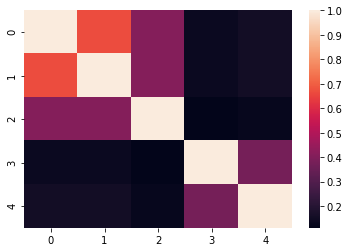

In [14]:
# Import the heatmap function from the seaborn library
from seaborn import heatmap

# Provide the cosine similarity matrix under 'sim' to the heatmap() function
heatmap(sim)

Each row and column in the heatmap represent a single *Doc*, whose numbers are given on the labels for vertical and horizontal axes. The bar on the right-hand side maps the colours to values for cosine similarity.

The heatmap shows a diagonal line across the table with values of 1.0, because each *Doc* is also compared to itself!

These *Docs* are naturally perfectly similar, which results in a value of 1.0.

Note also the high cosine similarity between *Docs* 0 and 1, which we can fetch from the list `docs`.

In [15]:
# Get Docs at indices [0] and [1] from the list 'docs'
docs[0], docs[1]

(Helsinki is the capital of Finland, Tallinn is the capital of Estonia)

Their cosine similarity is high, which means that the two *Docs* are close to each other in the 23-dimensional vector space, because they feature a similar combination of paradigmatic choices that form a syntagmatic structure ("is the capital of").

This illustrates how we can use vectors to describe *syntagmatic structures* by capturing paradigmatic choices that co-occur within some fixed unit or window of a given length (in our case, a clause).

The downside to this approach, however, is that when the size of the vocabulary increases, so does the length of the vector. For each new word, we must add another dimension for keeping track of its occurrences. As the vocabulary expands, the number of dimensions with a value of zero will also increase.

Furthermore, the vector does not contain information about the *order* in which the words appear. For this reason, such representations are often characterised using the term "[bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model)".

### A paradigmatic perspective

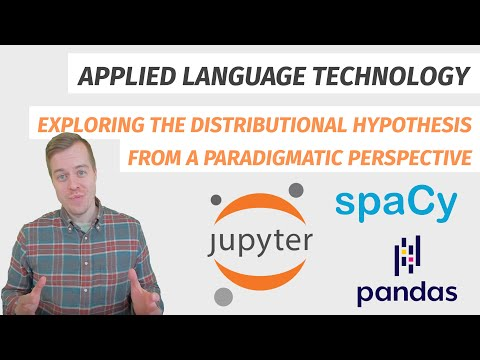

In [16]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('Zh600gBfn4o', height=350, width=600)

To explore the distributional hypothesis from a paradigmatic perspective, we must shift the target of description from co-occurrences of multiple words to individual words.

Just as we used vectors to represent syntagmatic structures above, we can do the same for individual words.

Let's start by taking the unique lemmas in our corpus of *Docs* stored in the list `docs`.

These can be easily retrieved from the *DataFrame* `df` by accessing the `columns` attribute, because the columns of the *DataFrame* correspond to the unique lemmas.

We then use the `tolist()` method to convert the output into a Python list.

In [17]:
# Retrieve the unique lemmas from the DataFrame and convert to list
unique_lemmas = df.columns.tolist()

# Call the variable to examine the output
unique_lemmas

['Estonia',
 'Finland',
 'Helsinki',
 'Tallinn',
 'a',
 'about',
 'and',
 'be',
 'between',
 'by',
 'capital',
 'connection',
 'depart',
 'downtown',
 'ferry',
 'from',
 'hour',
 'join',
 'of',
 'take',
 'the',
 'travel',
 'two']

This gives us a list of unique lemmas in the *Doc* objects.

To examine which words co-occur within a given distance of one another, we can create a new pandas *DataFrame* that uses the lemmas under `unique_lemmas` for defining both rows and columns.

To do so, we create a new *DataFrame* named `lemma_df` and provide the `unique_lemmas` list to the arguments `index` and `columns`.

Finally, we use the `fillna()` method of the *DataFrame* to replace NaN values with zeros.

In [18]:
# Create a new DataFrame with unique lemmas as row and columns, filled with zero values
lemma_df = pd.DataFrame(index=unique_lemmas, columns=unique_lemmas).fillna(0)

# Call the variable to examine the DataFrame
lemma_df

,Estonia,Finland,Helsinki,Tallinn,a,about,and,be,between,by,...,downtown,ferry,from,hour,join,of,take,the,travel,two
Estonia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Finland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Helsinki,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tallinn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
about,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
and,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
be,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
between,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
by,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This gives us an empty pandas *DataFrame* with 23 rows and 23 columns.

This *DataFrame* can be described as a *co-occurrence matrix*, which tracks how many times a lemma occurs within a given distance of another lemma (Sahlgren [2008](http://linguistica.sns.it/RdL/20.1/Sahlgren.pdf): 46).

The first step in exploring paradigmatic relations between words is to populate this *DataFrame* with co-occurrence counts, that is, how often the lemmas occur close to one another in the *Doc* objects stored under `docs`.

To make this effort easier, let's start by merging all the *Doc* objects in the list `docs` into a single *Doc* object.

To do so, we can use the `from_docs()` method of a spaCy *Doc* object.

In [19]:
# Import the Doc class from spacy.tokens
from spacy.tokens import Doc

# Create a new Doc object and use the 'from_docs()' method to combine the Docs
# in the existing list 'docs'. Assign result under 'combined_docs'.
combined_docs = Doc.from_docs(docs)

For current purposes, let's assume that two words on either side of a word constitute its neighbours.

We can use the `nbor()` method of a spaCy *Token* to fetch its neighbours.

The `nbor()` method takes an integer as input, which determines the position of the neighbour relative to the current *Token*. 

Negative integers refer to the indices of *Tokens* that come before the current *Token*, while positive integers refer to those that come after.

However, not all words have neighbours on both sides: the words that start or finish a sentence or some other sequence will not have preceding or following words.

To deal with this problem, we use the `try` and `except` statements in Python to catch the errors arising from missing neighbours, whose indices are not available.

In [20]:
# Loop over each Token in the Doc object
for token in combined_docs:
        
    # Loop over a range of positions. These represent indices
    # relative from the current index of the Token object.
    for position in [-2, -1, 1, 2]:
        
        # Try to execute following code block
        try: 
            
            # Use the nbor() method to get the neighbour of the
            # Token at the index determined by 'position'. Fetch
            # the lemma of the neighbouring Token.
            nbor_lemma = token.nbor(position).lemma_
            
            # Use the 'at' accessor to access rows and columns of the
            # DataFrame under 'lemma_df'. Increment (+=) existing value
            # by 1 to update the count!
            lemma_df.at[token.lemma_, nbor_lemma] += 1
        
        # If the code block raises an IndexError, execute
        # the code below
        except IndexError:
            
            # Move on to the next Token
            continue

This collects the co-occurrence counts into the *DataFrame*.

Let's examine the result by calling the variable `lemma_df`.

In [21]:
# Call the variable to examine the DataFrame
lemma_df

,Estonia,Finland,Helsinki,Tallinn,a,about,and,be,between,by,...,downtown,ferry,from,hour,join,of,take,the,travel,two
Estonia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
Finland,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
Helsinki,0,0,0,2,0,0,2,1,1,0,...,1,0,1,0,0,0,0,1,1,0
Tallinn,0,1,2,0,0,1,2,1,0,0,...,0,0,0,0,0,1,1,1,0,0
a,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
about,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
and,0,0,2,2,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
be,0,1,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,2,0,1
between,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
by,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0


As you can see, the *DataFrame* has now been populated with co-occurrence counts for each lemma.

Note that the values across rows and columns are identical, because the same categories (lemmas) are used for both.

The values on the rows/columns provide a vector for each lemma, which encode information about their collocated words. 

In other words, each lemma is characterised by a vector that describes its neighbours!

According to the distributional hypothesis, we would expect paradigmatic alternatives to have similar distributions.

To explore this idea, we can measure cosine similarity between these vectors using the `cosine_similarity` function that we imported from scikit-learn above.

Let's calculate cosine similarity between the vectors for "Tallinn" and "Helsinki".

In [22]:
# Get the vectors for 'Tallinn' and 'Helsinki' from the DataFrame.
# Use the 'values' attribute to access the data as a NumPy array.
tallinn_lemma_vector = lemma_df['Tallinn'].values
helsinki_lemma_vector = lemma_df['Helsinki'].values

# Measure cosine similarity between the two vectors. Note that the
# vectors must be wrapped into square brackets for input to this
# function. This gets the array into the right 'shape'.
cosine_similarity([tallinn_lemma_vector], [helsinki_lemma_vector])

array([[0.42857143]])

The result shows that the vectors for "Helsinki" and "Tallinn" are somewhat similar.

We could refine these representations by observing more data to get a better idea of how words are distributed, leading to better vector representations.

However, just as we observed for the syntagmatic structures, the dimensionality of the vector space grows every time we add a new word to the vocabulary.

## Learning word embeddings

So far, we have explored the distributional hypothesis from both syntagmatic and paradigmatic perspectives. 

We used vectors to represent both paradigmatic and syntagmatic structures, and applied different approaches to encode information about words and their distribution into these vectors.

For describing syntagmatic structures, we counted which words in the vocabulary occurred within the same clause, whereas for paradigmatic structures, we counted which words occurred close to one another.

We can think of both approaches as *abstraction mechanisms* that quantify linguistic information for representations using vectors.

We now continue this journey and focus on **word embeddings**, a technique for learning vector representations for linguistic units – such as words or sentences – directly from text. These representations are studied within the field of **distributional semantics**, which developed from the distributional hypothesis.

Boleda ([2020](https://doi.org/10.1146/annurev-linguistics-011619-030303): 214) defines distributional semantics succinctly:

> Distributional semantics represents word meaning by taking large amounts of text as input and, through an abstraction mechanism, producing a distributional model, akin to a lexicon, with semantic representations in the form of vectors – essentially, lists of numbers that determine points in a multidimensional space.

Compared to our previous efforts that involved counting co-occurrences and encoding this information into vectors, contemporary approaches to distributional semantics use algorithms as the abstraction mechanism (Baroni, Dinu & Kruszewski [2014](https://www.aclweb.org/anthology/P14-1023.pdf)).

Thus, in this section we explore the use of algorithms as the abstraction mechanism for learning vector representations for linguistic units.

### One-hot encoding

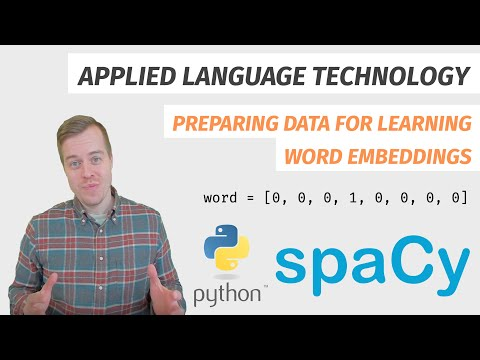

In [23]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('vQryFrk0xes', height=350, width=600)

To get started, we continue working with the data stored in the list `unique_lemmas`, and use a technique called *one-hot encoding* to represent each lemma using a vector.

One-hot encoding maps each lemma to a vector, which consists of zeros except at one dimension, where the value is 1. This dimension encodes the identity of a given word in the vocabulary.

You can think of this as one dimension being "hot" by having a value of 1, whereas all others are "cold" because their value is zero.

Let's examine this in practice by mapping each lemma in the list `unique_lemmas` to a corresponding one-hot vector.

To do so, we import *NumPy*, a Python library for working with arrays (Harris et al. [2020](https://doi.org/10.1038/s41586-020-2649-2)).

In [24]:
# Import NumPy, assign name 'np'
import numpy as np

# Define an empty placeholder dictionary for lemmas and their vectors
lemma_vectors = {}

# Loop over the list of unique lemmas; count items using enumerate()
for i, lemma in enumerate(unique_lemmas):
    
    # Create a vector with a length that corresponds to that of the
    # 'unique_lemmas' list. This matches the size of our vocabulary.
    # The np.zeros() function fills this vector with zeros.
    vector = np.zeros(shape=len(unique_lemmas))
    
    # Use the brackets to access the vector at the current index 'i',
    # which we retrieve during the loop over the list 'unique_lemmas'.
    # Set the value to one instead of zero at this position in the vector.
    vector[i] = 1
    
    # Store the lemma and vector into the dictionary
    lemma_vectors[lemma] = vector
    
    # Print out the vector and the lemma it corresponds to
    print(vector, lemma)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Estonia
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Finland
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Helsinki
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Tallinn
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] a
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] about
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] and
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] be
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] between
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] by
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] capital
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] connection
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

As you can see, dimensions that have a value of 1.0 form a diagonal line across the vectors.

This diagonal line emerges because each dimension of the vector encodes the identity of a unique lemma in the vocabulary.

To exemplify, the vector of the lemma "Estonia" must have a value of 1.0 in the first dimension, because this dimension encodes the identity of this lemma, whereas the values of all other dimensions must be zero, because they are reserved for the lemmas that come after.

Put differently, if the lemma is "Estonia", it must have a value of 1.0 in the first dimension. If the word is "Helsinki", the first dimension must have the value zero, but the third dimension must be 1.0, because this dimension is reserved for "Helsinki".

We can use one-hot vectors to encode sequences of words into numerical representations.

In [25]:
# Loop over Tokens in the first Doc in the list
for token in docs[0]:
    
    # Get the lemma of each token under the attribute 'lemma_'
    # and use this as a key for the 'lemma_vectors' dictionary
    # to retrieve the associated vector. Then print the lemma
    # itself.
    print(lemma_vectors[token.lemma_], token.lemma_)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Helsinki
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] be
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] the
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] capital
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] of
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Finland


We can join these vector representations of individual words into a *matrix*, which is like a "table" of vectors.

We can use NumPy's `vstack()` method to stack the vectors vertically, that is, place the vectors on top of each other to form a matrix that represents the entire *Doc*.

In [26]:
# Use a list comprehension to collect the vectors for each lemma in the first Doc
sentence_matrix = np.vstack([lemma_vectors[token.lemma_] for token in docs[0]])

# Call the variable to examine the output
sentence_matrix

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

We can examine the shape of the resulting matrix using the attribute `shape`.

In [27]:
# Get the attribute "shape" of the matrix under 'sentence_matrix'
sentence_matrix.shape

(6, 23)

The `shape` attribute contains the shape of the matrix: six rows, one for each lemma, which each have 23 dimensions that encode the identity of individual lemmas in the vocabulary.

A matrix such as this allows representing any sequence of *Tokens* numerically. 

However, once again, as the size of the vocabulary grows, so does the number of dimensions needed to represent each unique word in the vocabulary.

These vectors are also often characterised as *sparse*, because most dimensions of the vector do not encode any information, but consist of zeros.

To make the vector representation more efficient, *each dimension* of a vector should encode some information about the word and the context in which it occurs.

This can be achieved using by learning the word embeddings directly from the data using an algorithm as the abstraction mechanism.

In order to train an algorithm to predict neighbouring words, we must first collect the neighbours. For current purposes, let's continue to treat the two preceding and two following lemmas as neighbours.

In [28]:
# Define a list to hold Tokens and their neighbouring Tokens
pairs = []

# Loop over each Doc in the list of Docs under the variable 'docs'
for doc in docs:
    
    # Loop over each Token in a Doc
    for token in doc:
        
        # Loop over the indices of neighbouring Tokens that are of 
        # interest to us.
        for neighbour_i in [-2, -1, 1, 2]:
        
            # Try to retrieve neighbour at position 'neighbour_i'
            try:

                # Assign the preceding Token into the variable 'context'
                context = token.nbor(neighbour_i)
            
                # Append a tuple consisting of the current Token
                # and the neighbouring Token to the list 'pairs'
                pairs.append((token.lemma_, context.lemma_))
        
            # Use the except command to catch the error arising if 
            # there is no preceding Token ('IndexError')
            except IndexError:

                # Move to the next Token in the list of neighbours
                continue

This produces a list of tuples that contain word pairs that occur within two words of each other.

Let's print out the first 10 pairs to examine the result.

In [29]:
# Print out the first 10 tuples in the list 'pairs'
pairs[:10]

[('Helsinki', 'be'),
 ('Helsinki', 'the'),
 ('be', 'Helsinki'),
 ('be', 'the'),
 ('be', 'capital'),
 ('the', 'Helsinki'),
 ('the', 'be'),
 ('the', 'capital'),
 ('the', 'of'),
 ('capital', 'be')]

The first word in each tuple can be described as the **target** lemma, whereas the second word constitutes the **context** lemma.

To set the stage for making predictions, we must collect all target words in the list and their matching context words, and convert them into their one-hot encoded numerical representations. 

This can be achieved by a list comprehension, which loops over the tuples in the list `pairs`.

We can then fetch the one-hot encoded vector from the dictionary `lemma_vectors` by using the target lemma as the key.

In [30]:
# Define a list comprehension that collects target lemmas and stores
# the one-hot encoded vectors into a list named 'targets'
targets = [lemma_vectors[target] for target, context in pairs]

# Stack all the target lemmas into a matrix
targets = np.vstack(targets)

# Call the variable to check the size of the matrix
targets.shape

(118, 23)

Examining the `shape` attribute of the NumPy array under `targets` reveals that our data contains a total of 118 target lemmas.

In [31]:
# Get the first row in the array
targets[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

As you can see, the `targets` array contains one-hot vectors that encode the identity of lemmas, which were fetched from the `lemma_vectors` dictionary.

Next, we repeat the same operation for their context lemmas.

In [32]:
# Define a list comprehension that collects context lemmas and stores
# the one-hot encoded vectors into a list named 'context'
context = [lemma_vectors[context] for target, context in pairs]

# Stack all the context lemmas into a matrix
context = np.vstack(context)

# Call the variable to check the size of the matrix
context.shape

(118, 23)

Perfect! Each target lemma in `targets` now has a matching context lemma under `context`.

### Creating a neural network

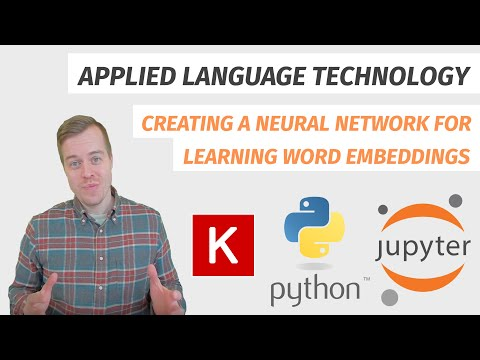

In [33]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('oiV75FgkhUU', height=350, width=600)

Next, we will define a small neural network, which attempts to learn a mapping between the vectors for target and context lemmas.

In other words, given a vector for the target word, the neural network attempts to predict the vector for the corresponding context lemma. 

To do so, we define a small neural network using a library named [Keras](https://keras.io/).

More specifically, we implement a variant of an algorithm for learning word embeddings called *Word2vec* (for *word to vector*), proposed by Tomas Mikolov et al. ([2013](https://arxiv.org/abs/1301.3781v3)).

Keras is a part of the TensorFlow deep learning library. We import both Keras and *Dense*, a specific type of neural network layer, from this library.

In [34]:
# Import the Keras module and the Dense class
from tensorflow import keras
from tensorflow.keras.layers import Dense

We start by defining an *Input* layer, which receives the one-hot encoded vectors stored under the variable `targets`.

We fetch the size of the second dimension (at index `[1]`) of the `targets` matrix available under the `shape` attribute. 

We then provide this information to the `shape` *argument* of the *Input* layer, because the neural network must know how many dimensions the inputs have. In our case, the number is 23.

We also use the `name` argument to name the layer as `input_layer`. 

We store the resulting *Input* object under the variable `network_input`.

In [35]:
# Create an input layer for the network; store under 'network_input'
network_input = keras.Input(shape=targets.shape[1], name='input_layer')

Next, we define a *Dense* layer with two neurons, as defined by the `units` argument.

Any layer between the input and output layers is referred to as a hidden layer.

We connect the *Input* layer to the hidden layer by placing the variable `network_input` in parentheses after the *Dense* layer:

```python
Dense(...)(network_input)
```

We assign the output from the *Dense* layer under variable `hidden_layer`.

In [36]:
# Create a hidden layer for the network; store under 'hidden_layer'
hidden_layer = Dense(units=2, activation=None, name='hidden_layer')(network_input)

To make predictions about which context lemmas occur close to the target lemmas, we define another *Dense* layer, whose `units` argument matches the size of our vocabulary.

This layer acts as the output layer of our network.

By setting the `activation` argument to `softmax`, the network will return probabilities for all lemmas in the vocabulary.

Put differently, when we provide an input word, we get back a probability distribution over the 23 lemmas in our vocabulary that sums up to approximately 1. 

In [37]:
# Create an output layer for the network; store under 'output_layer'
output_layer = Dense(units=context.shape[1], activation='softmax', name='output_layer')(hidden_layer)

We then combine the layers defined above into a network and assign the result under the variable `embedding_model`.

This is achieved using the *Model* object in Keras and its two arguments: `inputs` and `outputs`, to which we must provide the input and output layers of our network, that is, `input_layer` and `output_layer`.

In [38]:
# Create a Keras Model; store under 'embedding_model'
embedding_model = keras.Model(inputs=network_input, outputs=output_layer)

Finally, we use the `compile()` method to compile the model and define a loss function using the `loss` argument. 

The loss function approximates the error between predicted and actual context lemmas.

This error is used to adjust the "weights" of the neural network in a way that should potentially improve the predictions next time.

In [39]:
# Compile the model for training; define loss function
embedding_model.compile(loss='categorical_crossentropy')

To examine the resulting model, we call the `summary()` method.

In [40]:
# Print out a summary of the model
embedding_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2)                 48        
_________________________________________________________________
output_layer (Dense)         (None, 23)                69        
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


### Training a neural network

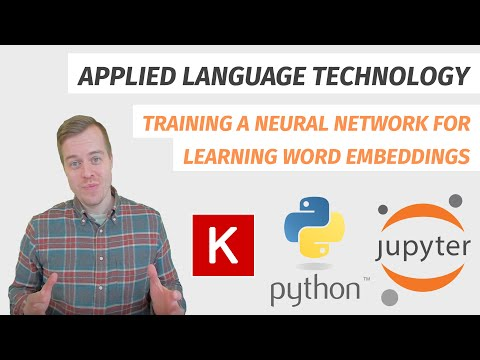

In [41]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('79dE6dKTriU', height=350, width=600)

We have now compiled a simple neural network. The network has a single hidden layer with two neurons, which acts as a bottleneck for information.

In other words, to learn how to predict the context lemmas based on the target lemmas, the model must learn to condense information contained in the sparse, 23-dimensional input vectors.

The next step is to train the model. This is done using the model's `fit()` function.

This function requires defining several arguments. The arguments `x` and `y` correspond to the inputs and outputs. These consist of the target and context lemmas, which are stored in the matrices under `targets` and `context`, respectively. 

We examine 64 pairs of target and context lemmas at the same time, as defined by the keyword `batch`, and loop over all pairs of lemmas 1500 times, as defined by the keyword `epochs`.

We also provide the `verbose` argument with a value of 0 to avoid flooding the notebook with status messages about the training procedure.

In [42]:
# Fit a model to the data
embedding_model.fit(x=targets,   # inputs
                    y=context,   # outputs
                    batch_size=64,  # how many pairs of words processed simultaneously
                    epochs=1500,   # how many times we loop through the whole data
                    verbose=0   # do not print training status
                   )

Now that the neural network has been trained, we can use the model to predict which context lemmas are likely to occur close to the target lemma.

Let's examine these predictions by retrieving the one-hot encoded vector for the lemma "be" and input this to the model.

To do so, we must use the `expand_dims()` function from NumPy to add a dummy axis in front of the vector, because our network expects to receive vectors in batches. This tells the network that the input consists of a single vector.

We store the input under the variable `input_array`.

In [43]:
# Add a dummy axis to the input vector
input_array = np.expand_dims(lemma_vectors['be'], axis=0)

# Check the shape of the input array
input_array.shape

(1, 23)

We then input the vector to the model using its `predict()` method, which returns an array of probabilities.

We store these probabilities under the variable `prediction`.

In [44]:
# Feed the input to the neural network; store predictions under 'prediction'
prediction = embedding_model.predict(input_array)

# Call the variable to examine the output
prediction

array([[0.01602018, 0.01614445, 0.09989536, 0.09349103, 0.00306099,
        0.02960719, 0.04491154, 0.14264156, 0.00339553, 0.01083017,
        0.14364119, 0.00073486, 0.00384828, 0.0047111 , 0.00240027,
        0.00487486, 0.02929394, 0.02575738, 0.05784808, 0.05205913,
        0.11483332, 0.00846422, 0.09153546]], dtype=float32)

These probabilities correspond to the unique lemmas in our vocabulary.

To examine which lemma is the most likely to occur in the neighbourhood of the lemma "be", we can use NumPy's `argmax()` function to find which dimension in the `prediction` vector has the highest value.

This gives us an integer, which we can use as an index for the list of lemmas under `unique_lemmas`.

In [45]:
# Index the list of unique lemmas using the integer returned by np.argmax()
unique_lemmas[np.argmax(prediction)]

'capital'

And now comes the interesting part: predicting the most likely neighbour(s) of a given lemma **is not the actual goal** of the training procedure, but this task is **a proxy for the true objective**: to learn numerical representations for individual words. 

To predict context lemmas, the network must learn useful representations for target lemmas. One may think of these numerical representations as the identity of the word, which was initially encoded using a one-hot vector.

These representations can be acquired from the **hidden layer** of the neural network, which contains two neurons. 

The neurons of the hidden layer have *parameters*, commonly referred to as *weights*, which are adjusted as the network learns to improve its predictions based on the error estimated by the loss function.

The weights of a model can be retrieved using the `get_weights()` method of a Keras *Model*.

In [46]:
# Retrieve model weights; assign the resulting list to 'model_weights'
model_weights = embedding_model.get_weights()

# The weights of the hidden layer are the first item in the list
hidden_layer_weights = model_weights[0]

# Call the variable and use the 'shape' attribute to examine size
hidden_layer_weights.shape

(23, 2)

The weights of the hidden layer consist of 23 two-dimensional vectors, one two-dimensional vector for each unique lemma in the vocabulary.

Let's print out the first five vectors to examine their values.

In [47]:
# Check out the first five items in the weight matrix
hidden_layer_weights[:5]

array([[ 2.4749715 , -2.2944055 ],
       [ 2.0351472 , -2.1772954 ],
       [-0.5708338 , -0.30606478],
       [ 1.2933655 ,  0.75066346],
       [-1.0590161 ,  1.6461867 ]], dtype=float32)

In contrast to the sparse one-hot encoded vectors, the representations learned by the hidden layer may be characterised as **dense**, as each dimension of the vector encodes some information.

We can think of these two-dimensional values as coordinates and plot these dimensions against each other to examine position of each lemma in the two-dimensional space.

This represents the *embedding space* for the vectors.

To visualise the embedding space and the vectors within this space, we use a dictionary comprehension to map each unique lemma to its two-dimensional representation in the hidden layer.

In [48]:
# Collect hidden layer weights into a dictionary using a dictionary comprehension
lemma_embeddings = {lemma: hidden_layer_weights[i] for i, lemma in enumerate(unique_lemmas)}

We then import the *matplotlib* library and create a figure. The `dpi` argument sets the resolution of the figure to 150 dots per inch.

We then loop over the lemmas and their vector representations in the `lemma_embeddings` dictionary. 

The `items()` method of a dictionary returns both keys and values, which we then add to the *matplotlib* figure.

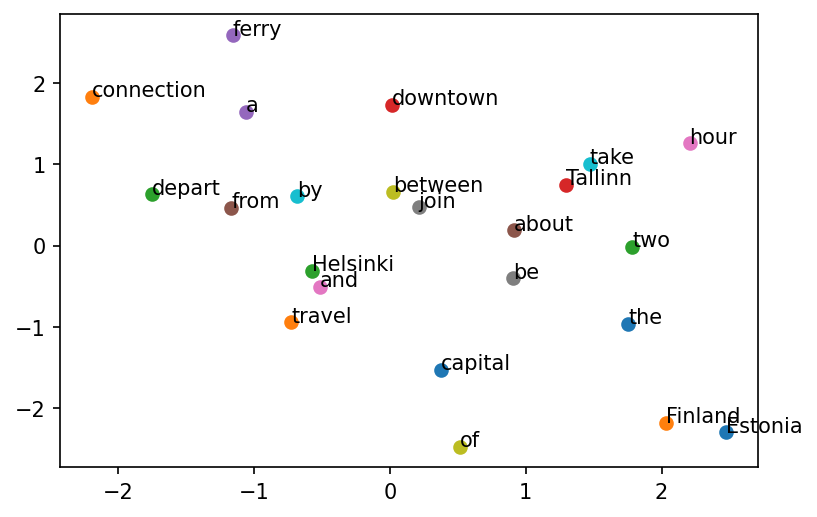

In [49]:
# This tells Jupyter to render the matplotlib plot in the Notebook
%matplotlib inline

# Import the pyplot component from matplotlib
import matplotlib.pyplot as plt

# Create a figure with a resolution of 150 DPI
plt.figure(dpi=150)

# Loop over the key/value pairs in the dictionary
for lemma, coordinates in lemma_embeddings.items():

    # Unpack the coordinates variable into two variables
    # These stand for the horizontal/vertical coordinates
    x, y = coordinates[0], coordinates[1]
    
    # Use the scatter() method to add the x and y coordinates
    # to the figure
    plt.scatter(x, y)
    
    # Use the annotate() method to add the lemmas as labels 
    # to the coordinate pairs, which must be wrapped into a tuple
    plt.annotate(lemma, (x, y))

We can now visualise each lemma as a point in the two-dimensional embedding space by plotting the dimensions against each other.

This allows examining the outcome from the perspective of the distributional hypothesis, which suggests that the vectors of lemmas that occur in similar linguistic contexts should be close to each other in the embedding space.

Having access to more data (and a larger vocabulary) would allow the model to learn more about word co-occurrences, which would enable learning better representations for lemmas in the embedding space.

The embedding space could also be extended by increasing the number of neurons in the hidden layer of the neural network. This kind of added "capacity" would allow the model to learn more complex representations for individual words. It is common for word vectors to have several hundred dimensions, which all capture some information about the word and its distribution. 

This section should have given you a basic understanding of the distributional hypothesis, which underlies the notion of word embeddings and research on distributional semantics.

You should also understand how word embeddings are learned directly from the data using a proxy task, such as predicting the neighbouring word.

However, note that the toy example presented above merely scratches the surface of how word embeddings are learned.

Contemporary approaches to learning word embeddings use neural networks with complex architectures and billions of parameters, which also attempt to encode more information about the neighbouring words, in order to distinguish between homonymic forms such as "bank" as a financial institution and "bank" as an area close to the river.

In the following [section](05_embeddings_continued.ipynb), we dive deeper into word embeddings and how they can be used in spaCy.